Tutorial 1: Search Chaining
===========================

In chapter 2, we learnt how to perform lens modeling using a non-linear search. In all of the tutorials, we fitted the
data using just one non-linear search. In this chapter, we introduce a technique called 'non-linear search chaining',
fits a lens model using a sequence of non-linear searches. The initial searches fit simpler lens model whose parameter
spaces can be more accurately and efficiently sampled. The results of this search are then passed to later searches
which fit lens models of gradually increasing complexity.

Lets think back to tutorial 4 of chapter 2. We learnt there were three approaches one could take fitting a lens model
accurately if we found that a model fit failed. These were:

 1) Tuning our priors to the strong lens we're fitting.
 2) Making our lens model less complex.
 3) Searching non-linear parameter space for longer.

However, each of the above approaches has disadvantages. The more we tune our priors, the less we can generalize our
analysis to a different strong lens. The less complex we make our model, the less realistic it is. And if we rely too
much on searching parameter space for longer, we could end up with search`s that take days, weeks or months to run.

In this tutorial, we are going to show how search chaining combines these 3 approaches such that we can fit
complex and realistic lens models in a way that that can be generalized to many different strong lenses. To do this,
we'll run 2 searches, and chain the lens model inferred in the first search to the priors of the second search`s lens
model.

Our first search will make the same light-traces-mass assumption we made in the previous tutorial. We saw that this
gives a reasonable lens model. However, we'll make a couple of extra simplifying assumptions, to really try and bring
our lens model complexity down and get the non-linear search running fast.

The model we infer above will therefore be a lot less realistic. But it does not matter, because in the second search
we're going to relax these assumptions and fit the more realistic lens model. The beauty is that, by running the first
search, we can use its results to tune the priors of our second search. For example:

 1) The first search should give us a pretty good idea of the lens galaxy's light and mass profiles, for example its
 intensity, effective radius and einstein radius.

 2) It should also give us a pretty good fit to the lensed source galaxy. This means we'll already know where in
 source-plane its is located and what its intensity and effective are.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

import numpy as np
from os import path
import autolens as al
import autolens.plot as aplt
import autofit as af

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


__Initial Setup__

we'll use the same strong lensing data as the previous tutorial, where:

 - The lens galaxy's light is an `EllSersic`.
 - The lens galaxy's total mass distribution is an `EllIsothermal` and `ExternalShear`.
 - The source galaxy's `LightProfile` is an `EllExponential`.

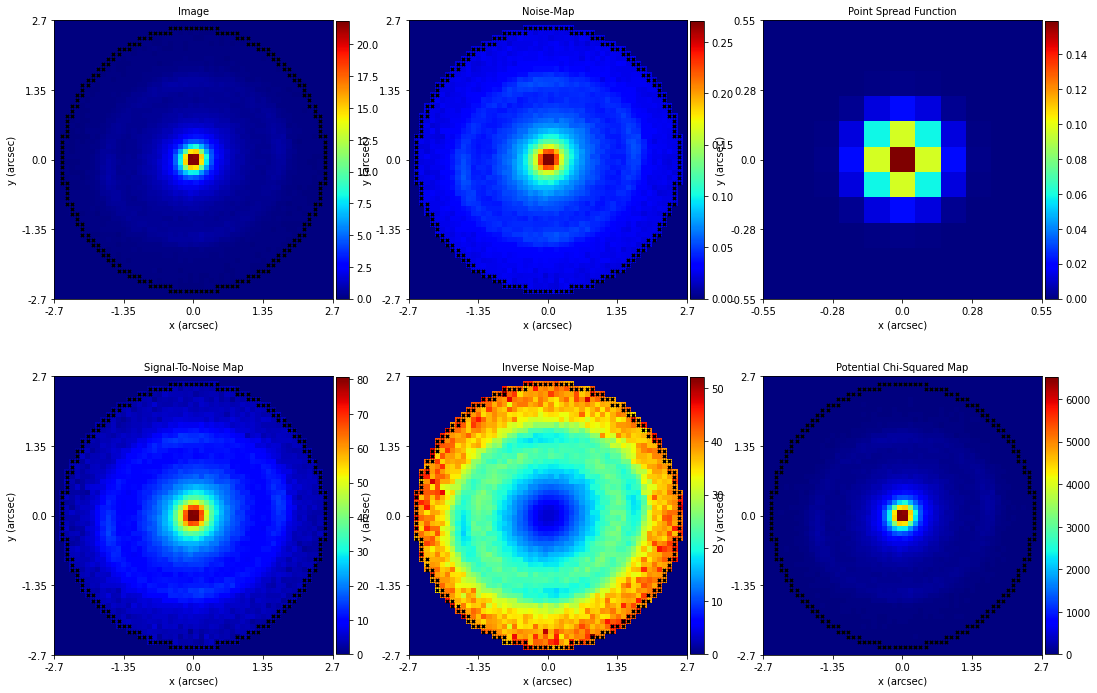

In [2]:
dataset_name = "light_sersic__mass_sie__source_sersic"
dataset_path = path.join("dataset", "imaging", "with_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.1,
)

mask = al.Mask2D.circular(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales, radius=2.6
)

imaging = imaging.apply_mask(mask=mask)

imaging_plotter = aplt.ImagingPlotter(
    imaging=imaging, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter.subplot_imaging()

__Model__

As we've eluded to before, one can look at an image and immediately identify the centre of the lens galaxy. It's 
that bright blob of light in the middle! Given that we know we're going to make the lens model more complex in the 
next search, lets take a more liberal approach than before and fix the lens centre to $(y,x)$ = (0.0", 0.0").

Now, you might be thinking, doesn`t this prevent our search from generalizing to other strong lenses? What if the 
centre of their lens galaxy isn't at (0.0", 0.0")?

Well, this is true if our dataset reduction centres the lens galaxy somewhere else. But we get to choose where we 
centre it when we make the image. Therefore, I`d recommend you always centre the lens galaxy at the same location, 
and (0.0", 0.0") seems the best choice!

In [3]:
bulge = af.Model(al.lp.EllSersic)
mass = af.Model(al.mp.EllIsothermal)

You haven't actually seen a line like this one before. By setting a parameter to a number (and not a prior) it is be 
removed from non-linear parameter space and always fixed to that value. Pretty neat, huh?

In [4]:
bulge.centre_0 = 0.0
bulge.centre_1 = 0.0
mass.centre_0 = 0.0
mass.centre_1 = 0.0

Lets use the same approach of making the ellipticity of the mass trace that of the sersic.

In [5]:
mass.elliptical_comps = bulge.elliptical_comps

We also discussed that the Sersic index of most lens galaxies is around 4. Lets fix it to 4 this time.

In [6]:
bulge.sersic_index = 4.0

We now compose the model with these components that have had their priors customized. 

We have not done anything to the source model, but use an `EllExponential` which will become the more complex
`EllSersic` in the second search.

In [7]:
lens = af.Model(
    al.Galaxy, redshift=0.5, bulge=bulge, mass=mass, shear=al.mp.ExternalShear
)

source = af.Model(al.Galaxy, redshift=1.0, bulge=al.lp.EllExponential)

model = af.Collection(galaxies=af.Collection(lens=lens, source=source))

__Search + Analysis__

Now lets create the search and analysis.

In [8]:
search = af.DynestyStatic(
    path_prefix=path.join("howtolens", "chapter_3"),
    name="tutorial_1_search_chaining_1",
    n_live_points=50,
)

analysis = al.AnalysisImaging(dataset=imaging)

Lets run the search, noting that our liberal approach to reducing the lens model complexity has reduced it to just 
11 parameters.

In [9]:
print(
    "Dynesty has begun running - checkout the workspace/output/5_chaining_searches"
    " folder for live output of the results, images and lens model."
    " This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!"
)

result_1 = search.fit(model=model, analysis=analysis)

print("Dynesty has finished run - you may now continue the notebook.")

INFO:root:tutorial_1_search_chaining_1 already completed, skipping non-linear search.


Dynesty has begun running - checkout the workspace/output/5_chaining_searches folder for live output of the results, images and lens model. This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!
Dynesty has finished run - you may now continue the notebook.


__Result__

And indeed, we get a reasonably good model and fit to the data, in a much shorter space of time!

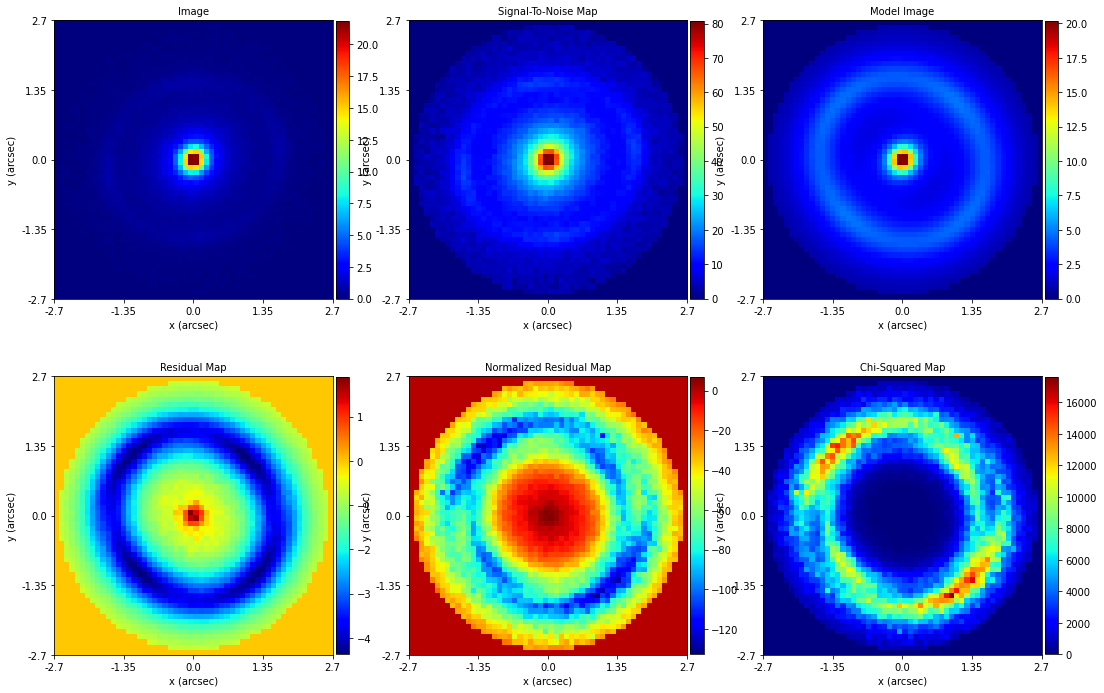

In [10]:
fit_imaging_plotter = aplt.FitImagingPlotter(fit=result_1.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()

__Prior Passing__

Now all we need to do is look at the results of search 1 and pass the results as priors for search 2. Lets setup 
a custom search that does exactly that.

GaussianPriors are a nice way to pass priors. They tell the non-linear search where to look, but leave open the 
possibility that there might be a better solution nearby. In contrast, UniformPriors put hard limits on what values a 
parameter can or can`t take. It makes it more likely we will accidently cut-out the global maxima solution.

In [11]:
bulge = af.Model(al.lp.EllSersic)
mass = af.Model(al.mp.EllIsothermal)
shear = af.Model(al.mp.ExternalShear)
source_bulge = af.Model(al.lp.EllSersic)

What I've done below is looked at the results of search 1 and manually specified a prior for every parameter. If a 
parameter was fixed in the previous search, its prior is based around the previous value. Don't worry about the sigma 
values for now, I've chosen values that I know will ensure reasonable sampling, but we'll cover this later.

__LENS LIGHT PRIORS:__

In [12]:
bulge.centre.centre_0 = af.GaussianPrior(
    mean=0.0, sigma=0.1, lower_limit=-np.inf, upper_limit=np.inf
)
bulge.centre.centre_1 = af.GaussianPrior(
    mean=0.0, sigma=0.1, lower_limit=-np.inf, upper_limit=np.inf
)
bulge.elliptical_comps.elliptical_comps_0 = af.GaussianPrior(
    mean=0.33333, sigma=0.15, lower_limit=-1.0, upper_limit=1.0
)
bulge.elliptical_comps.elliptical_comps_1 = af.GaussianPrior(
    mean=0.0, sigma=0.2, lower_limit=-1.0, upper_limit=1.0
)
bulge.intensity = af.GaussianPrior(
    mean=1.1, sigma=0.01, lower_limit=0.0, upper_limit=np.inf
)
bulge.effective_radius = af.GaussianPrior(
    mean=0.72, sigma=0.2, lower_limit=0.0, upper_limit=np.inf
)
bulge.sersic_index = af.GaussianPrior(
    mean=4.0, sigma=2.0, lower_limit=0.0, upper_limit=np.inf
)

__LENS MASS PRIORS:__

In [13]:
mass.centre.centre_0 = af.GaussianPrior(
    mean=0.0, sigma=0.1, lower_limit=-np.inf, upper_limit=np.inf
)
mass.centre.centre_1 = af.GaussianPrior(
    mean=0.0, sigma=0.1, lower_limit=-np.inf, upper_limit=np.inf
)
mass.elliptical_comps.elliptical_comps_0 = af.GaussianPrior(
    mean=0.33333, sigma=0.15, lower_limit=-1.0, upper_limit=1.0
)
mass.elliptical_comps.elliptical_comps_1 = af.GaussianPrior(
    mean=0.0, sigma=0.2, lower_limit=-1.0, upper_limit=1.0
)
mass.einstein_radius = af.GaussianPrior(
    mean=1.6, sigma=0.1, lower_limit=0.0, upper_limit=np.inf
)
shear.elliptical_comps.elliptical_comps_0 = af.GaussianPrior(mean=0.05, sigma=0.05)
shear.elliptical_comps.elliptical_comps_1 = af.GaussianPrior(mean=0.05, sigma=0.05)

__SOURCE LIGHT PRIORS:__

In [14]:
source_bulge.centre.centre_0 = af.GaussianPrior(
    mean=0.0, sigma=0.1, lower_limit=-np.inf, upper_limit=np.inf
)
source_bulge.centre.centre_1 = af.GaussianPrior(
    mean=0.0, sigma=0.1, lower_limit=-np.inf, upper_limit=np.inf
)
source_bulge.elliptical_comps.elliptical_comps_0 = af.GaussianPrior(
    mean=0.43, sigma=0.15, lower_limit=-1.0, upper_limit=1.0
)
source_bulge.elliptical_comps.elliptical_comps_1 = af.GaussianPrior(
    mean=0.23, sigma=0.2, lower_limit=-1.0, upper_limit=1.0
)
source_bulge.intensity = af.GaussianPrior(
    mean=0.17, sigma=0.05, lower_limit=0.0, upper_limit=np.inf
)
source_bulge.effective_radius = af.GaussianPrior(
    mean=0.14, sigma=0.2, lower_limit=0.0, upper_limit=np.inf
)
source_bulge.sersic_index = af.GaussianPrior(
    mean=1.0, sigma=3.0, lower_limit=0.0, upper_limit=np.inf
)

We now compose the model with these components that have had their priors customized. 

In [15]:
lens = af.Model(al.Galaxy, redshift=0.5, bulge=bulge, mass=mass)

source = af.Model(al.Galaxy, redshift=1.0, bulge=source_bulge)

model = af.Collection(galaxies=af.Collection(lens=lens, source=source))

Lets setup and run the search. As expected, it gives us the correct lens model. However, it does so significantly 
faster than we are used to!

In [16]:
search = af.DynestyStatic(
    path_prefix=path.join("howtolens", "chapter_3"),
    name="tutorial_1_search_chaining_2",
    n_live_points=50,
)

print(
    "Dynesty has begun running - checkout the workspace/output/5_chaining_searches"
    " folder for live output of the results, images and lens model."
    " This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!"
)

result_2 = search.fit(model=model, analysis=analysis)

print("Dynesty has finished run - you may now continue the notebook.")

INFO:root:tutorial_1_search_chaining_2 already completed, skipping non-linear search.


Dynesty has begun running - checkout the workspace/output/5_chaining_searches folder for live output of the results, images and lens model. This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!
Dynesty has finished run - you may now continue the notebook.


__Result__

Look at that, the right lens model, again!

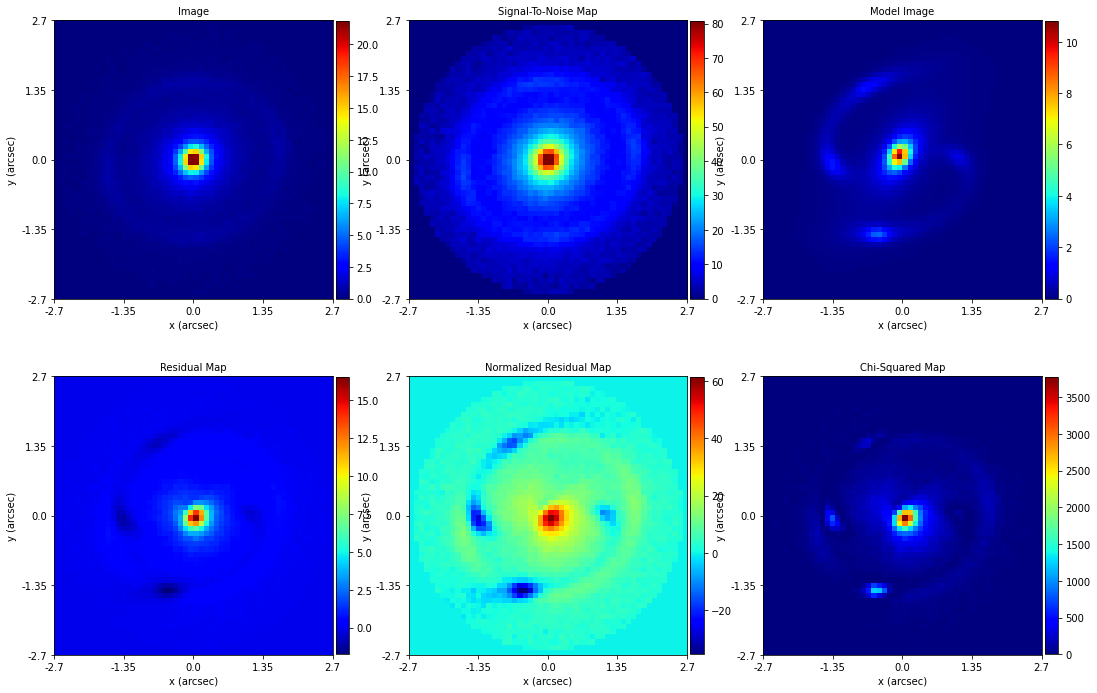

In [17]:
fit_imaging_plotter = aplt.FitImagingPlotter(fit=result_2.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()

__Wrap Up__

Chaining two searches together was a huge success. We managed to fit a complex and realistic model, but were able to 
begin by making simplifying assumptions that eased our search of non-linear parameter space. We could apply search 1 to 
pretty much any strong lens and therefore get ourselves a decent lens model with which to tune search 2`s priors.

You are probably thinking though that there is one huge, giant, glaring flaw in all of this that I've not mentioned. 
Search 2 can`t be generalized to another lens, because its priors are tuned to the image we fitted. If we had a lot 
of lenses, we`d have to write a new search for every single one. This isn't ideal, is it?

Fortunately, we can pass priors in **PyAutoLens** without specifying the specific values. The API for this technique,
called prior passing, is the topic of the next tutorial.